In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from matplotlib import pyplot as plt

In [2]:
tabela = pd.read_csv('../input/isic-2019-reorganized/ISIC_2019_Training_GroundTruth-reo.csv')
tabela['image'] = tabela['image'].astype(str) + '.jpg'
tabela

,image,dx
0,ISIC_0024329.jpg,scc
1,ISIC_0024372.jpg,scc
2,ISIC_0024418.jpg,scc
3,ISIC_0024450.jpg,scc
4,ISIC_0024463.jpg,scc
...,...,...
25326,ISIC_0073231.jpg,mel
25327,ISIC_0073237.jpg,mel
25328,ISIC_0073238.jpg,mel
25329,ISIC_0073241.jpg,mel


In [3]:
tabela.groupby('dx')['dx'].count()

dx
ak        867
bcc      3323
bkl      2624
df        239
mel      4522
nv      12875
scc       628
vasc      253
Name: dx, dtype: int64

In [4]:
t_ak = tabela.loc[tabela['dx'] == 'ak']
oznake = tabela['dx'].unique()
redukovana_tabela = pd.DataFrame({'image': [], 'dx': []})
for oznaka in (('bcc','mel')):
    t = tabela.loc[tabela['dx'] == oznaka]
    redukovana_tabela = pd.concat([redukovana_tabela,t],axis = 0)
redukovana_tabela
t = tabela.loc[tabela['dx']=='nv']
t = t.sample(n=5000)
redukovana_tabela =  pd.concat([redukovana_tabela,t],axis = 0)

In [5]:
osnova_modela = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299, 3),
)
#osnova_modela.summary()

2022-06-14 16:51:24.504067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 16:51:24.622557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 16:51:24.623410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 16:51:24.624527: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [6]:
model = tf.keras.models.Sequential()
model.add(osnova_modela)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 393219    
Total params: 22,196,003
Trainable params: 22,161,571
Non-trainable params: 34,432
_________________________________________________________________


In [7]:
y = redukovana_tabela['dx']
sklearn_weights = sklearn.utils.class_weight.compute_class_weight('balanced',classes = np.unique(y), y = y)
sklearn_weights_dict = dict(enumerate(sklearn_weights))
sklearn_weights_dict

{0: 1.2884943324305347, 1: 0.9468524251805985, 2: 0.8563333333333333}

In [8]:
from sklearn.model_selection import train_test_split
Y = redukovana_tabela.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(redukovana_tabela,Y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.1, random_state = 42)

In [9]:
train = pd.concat([X_train, y_train], axis = 1)
val = pd.concat([X_val, y_val], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx'])
val['label'] = name_as_indexes_train
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test
val

,image,dx,label
10943,ISIC_0025847.jpg,nv,2
6447,ISIC_0062946.jpg,bcc,0
12185,ISIC_0027641.jpg,nv,2
15615,ISIC_0032619.jpg,nv,2
9987,ISIC_0024440.jpg,nv,2
...,...,...,...
5030,ISIC_0031986.jpg,bcc,0
5401,ISIC_0055441.jpg,bcc,0
6399,ISIC_0062601.jpg,bcc,0
9511,ISIC_0014760_downsampled.jpg,nv,2


In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, 
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     rotation_range=20,
                                     )
train_data = train_generator.flow_from_dataframe(dataframe = train, x_col = 'image', y_col = 'dx', batch_size = 64, directory = '../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input',
                                                 shuffle = True, class_mode = 'categorical', target_size = (299, 299))

Found 10404 validated image filenames belonging to 3 classes.


In [12]:
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_data = train_generator.flow_from_dataframe(dataframe = val, x_col = 'image', y_col = 'dx', batch_size = 1, directory = '../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input',
                                               shuffle = True, class_mode = 'categorical', target_size = (299,299))

Found 1156 validated image filenames belonging to 3 classes.


In [13]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_data = train_generator.flow_from_dataframe(dataframe = test, x_col = 'image', y_col = 'dx', batch_size = 1, directory = '../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input',
                                                 shuffle = False, class_mode = 'categorical', target_size = (299,299))

Found 1285 validated image filenames belonging to 3 classes.


In [14]:
METRICS = [ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
initial_learning_rate = 5e-4
epochs = 25
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
learning_control = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose =1)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)
adam = tf.keras.optimizers.Adam(learning_rate = 5e-4)
model.compile ( optimizer = adam, loss = 'categorical_crossentropy', metrics = METRICS)

In [15]:
history = model.fit(train_data, steps_per_epoch = train_data.samples//train_data.batch_size,
                              validation_data = val_data,
                              class_weight = sklearn_weights_dict,
                              epochs = 25,
                              callbacks = [learning_control, early_stop])

2022-06-14 16:51:52.937428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005000000237487257.


2022-06-14 16:52:03.422090: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


162/162 [==============================] - 589s 4s/step - loss: 1.1190 - accuracy: 0.6081 - precision: 0.4551 - recall: 0.8897 - val_loss: 1.4319 - val_accuracy: 0.6130 - val_precision: 0.4481 - val_recall: 0.6946
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0004999900239482468.
162/162 [==============================] - 430s 3s/step - loss: 0.5281 - accuracy: 0.7478 - precision: 0.5736 - recall: 0.9485 - val_loss: 262.5341 - val_accuracy: 0.6459 - val_precision: 0.4803 - val_recall: 0.7604
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0004999700132305193.
162/162 [==============================] - 431s 3s/step - loss: 0.5694 - accuracy: 0.7374 - precision: 0.5632 - recall: 0.9452 - val_loss: 0.5094 - val_accuracy: 0.7255 - val_precision: 0.5515 - val_recall: 0.9455
Epoch 4/25

Epoch 00004: LearningRateScheduler setting learning rate to 0.0004999399921961626.
162/162 [==============================] - 433s 3s/step - loss: 0.4307 

In [16]:
model.save_weights('my_model_weights.h5')

<function matplotlib.pyplot.show(close=None, block=None)>

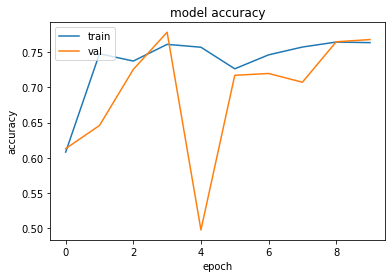

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show

In [18]:
test_data.reset()
predictions = model.predict(test_data, steps = test_data.samples/test_data.batch_size, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
c = np.where(y_pred == name_as_indexes_test)
print('Preciznost je: ', (np.count_nonzero(c)/len(name_as_indexes_test))*100)

1285/1285 [==============================] - 70s 54ms/step
Preciznost je:  79.14396887159533


In [19]:
from sklearn.metrics import classification_report

report = classification_report(name_as_indexes_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       332
           1       0.82      0.63      0.71       455
           2       0.76      0.83      0.80       498

    accuracy                           0.79      1285
   macro avg       0.80      0.81      0.79      1285
weighted avg       0.80      0.79      0.79      1285

